In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml

In [ ]:
# 데이터 로드
data = fetch_openml(name='adult', version=1, as_frame=True)
df = data.frame

# 데이터 전처리 함수
def preprocess_dataframe(df):
    df_processed = df.copy()

    for column in df_processed.columns:
        # 카테고리 처리
        if df_processed[column].dtype == 'category' or df_processed[column].dtype == 'object':
            # 'Unknown' 카테고리 추가
            if pd.api.types.is_categorical_dtype(df_processed[column]):
                df_processed[column] = df_processed[column].cat.add_categories(['Unknown'])
            # 결측값 대체
            df_processed[column] = df_processed[column].fillna('Unknown')

            # 레이블 인코딩
            le = LabelEncoder()
            df_processed[column] = le.fit_transform(df_processed[column].astype(str))

        # 수치형 처리
        elif df_processed[column].dtype in ['int64', 'float64']:
            # 결측값 중앙값으로 대체
            df_processed[column] = df_processed[column].fillna(df_processed[column].median())

    return df_processed

# 데이터 전처리
df_processed = preprocess_dataframe(df)

In [ ]:
# 특성과 타겟 분리
X_data = df_processed.drop('class', axis=1)
y_data = df_processed['class']

# 이진 클래스 레이블 변환
y_data = (y_data == 1).astype(int)

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=42)

<ipython-input-54-6ece3b9c03c8>:26: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(df_processed[column]):
<ipython-input-54-6ece3b9c03c8>:26: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(df_processed[column]):
<ipython-input-54-6ece3b9c03c8>:26: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(df_processed[column]):
<ipython-input-54-6ece3b9c03c8>:26: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(df_processed[column]):
<ipython-input-54-6e

Epoch [1/10], Loss: 0.3714, Test Accuracy: 84.01%


 20%|██        | 2/10 [00:09<00:37,  4.72s/it]

Epoch [2/10], Loss: 0.3350, Test Accuracy: 84.59%


 30%|███       | 3/10 [00:15<00:36,  5.19s/it]

Epoch [3/10], Loss: 0.3291, Test Accuracy: 84.60%


 40%|████      | 4/10 [00:19<00:29,  4.86s/it]

Epoch [4/10], Loss: 0.3264, Test Accuracy: 84.39%


 50%|█████     | 5/10 [00:26<00:28,  5.68s/it]

Epoch [5/10], Loss: 0.3251, Test Accuracy: 84.91%


 60%|██████    | 6/10 [00:31<00:21,  5.31s/it]

Epoch [6/10], Loss: 0.3237, Test Accuracy: 84.69%


 70%|███████   | 7/10 [00:36<00:15,  5.14s/it]

Epoch [7/10], Loss: 0.3215, Test Accuracy: 84.78%


 80%|████████  | 8/10 [00:41<00:10,  5.28s/it]

Epoch [8/10], Loss: 0.3213, Test Accuracy: 84.80%


 90%|█████████ | 9/10 [00:46<00:05,  5.03s/it]

Epoch [9/10], Loss: 0.3210, Test Accuracy: 85.24%


100%|██████████| 10/10 [00:51<00:00,  5.13s/it]

Epoch [10/10], Loss: 0.3209, Test Accuracy: 84.58%


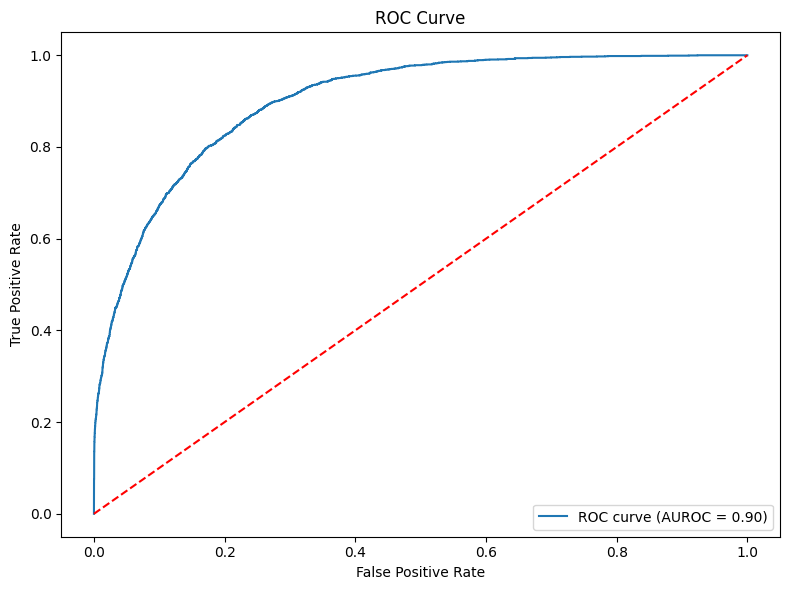

AUROC: 0.9004


In [ ]:
# 데이터 표준화
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# PyTorch 텐서로 변환
X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train.values)
y_test = torch.LongTensor(y_test.values)

# DataLoader 생성
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

# 컬럼 간 상호작용 클래스
class ColumnWiseInteraction(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.interaction_weights = nn.Parameter(torch.randn(input_dim, input_dim))

    def forward(self, x):
        interactions = torch.matmul(x, self.interaction_weights)
        return torch.cat([x, interactions], dim=1)

# Transformer 기반 분류 모델
class TransformerClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_heads, num_classes):
        super().__init__()
        self.column_interaction = ColumnWiseInteraction(input_dim)
        self.positional_encoding = nn.Parameter(torch.randn(1, input_dim * 2))

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=input_dim * 2,
            nhead=num_heads,
            dim_feedforward=hidden_dim
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=2)

        self.classifier = nn.Sequential(
            nn.Linear(input_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, num_classes)
        )

    def forward(self, x):
        x = self.column_interaction(x)
        x = x + self.positional_encoding.expand_as(x)
        x = x.unsqueeze(0)
        x = self.transformer_encoder(x)
        x = x.squeeze(0)
        return self.classifier(x)

# 모델 학습 함수
def train_model(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

# 모델 평가 함수
def evaluate_model(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            outputs = model(batch_x)
            _, predicted = torch.max(outputs.data, 1)
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()
    return 100 * correct / total

# AUROC 계산 및 시각화 함수
def calculate_and_plot_auroc(model, test_loader, device):
    model.eval()
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            outputs = torch.softmax(model(batch_x), dim=1)
            probs = outputs[:, 1].cpu().numpy()
            labels = batch_y.cpu().numpy()
            all_probs.extend(probs)
            all_labels.extend(labels)

    auroc = roc_auc_score(all_labels, all_probs)
    fpr, tpr, thresholds = roc_curve(all_labels, all_probs)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC curve (AUROC = {auroc:.2f})')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

    return auroc

# 메인 함수
def main():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    input_dim = X_train.shape[1]
    hidden_dim = 128
    num_heads = 4
    num_classes = 2

    model = TransformerClassifier(input_dim, hidden_dim, num_heads, num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    num_epochs = 10
    for epoch in tqdm(range(num_epochs)):
        train_loss = train_model(model, train_loader, criterion, optimizer, device)
        test_acc = evaluate_model(model, test_loader, device)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}, Test Accuracy: {test_acc:.2f}%')

    auroc = calculate_and_plot_auroc(model, test_loader, device)
    print(f'AUROC: {auroc:.4f}')


main()
